In [1]:
from google.colab import drive
drive.mount('/content/derive')

Drive already mounted at /content/derive; to attempt to forcibly remount, call drive.mount("/content/derive", force_remount=True).


In [2]:
!pip install -U mxnet-cu101==1.7.0

Requirement already up-to-date: mxnet-cu101==1.7.0 in /usr/local/lib/python3.7/dist-packages (1.7.0)


In [3]:
!nvidia-smi

Wed Jun 30 06:09:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import sys
sys.path.append('/content/derive/MyDrive/Code')



Krill Herd Optimization
Enter the number of iterations : 5
Enter the number of krills : 5
Type M for manual scramble or R for random scrabmle : R
B2 L' R F B R2 D2 F U R F U R2 D L2 F2 U R D B' L' U' F2 D2 R' U2 L2 R D' [29]

Scramble :  B2 L' R F B R2 D2 F U R F U R2 D L2 F2 U R D B' L' U' F2 D2 R' U2 L2 R D' 
Initial cube orientation:  brbwygybwryrrobgyogwggggwrobbygwowwbwrrbroowryyoyboyog
Initial Fitnees :  20


Maximum Iteration :  5
Total Population :  5


Iteration :  0
********** Edge Selection Stage **********
Krill :  0 Orientation :  brbwygybwryrrobgyogwggggwrobbygwowwbwrrbroowryyoyboyog Current Fitnees :  20 Method : Greedy Move :  D' New Fitnees :  19
Krill :  1 Orientation :  brbwygybwryrrobgyogwggggwrobbygwowwbwrrbroowryyoyboyog Current Fitnees :  20 Method : Greedy Move :  U New Fitnees :  19
Krill :  2 Orientation :  brbwygybwryrrobgyogwggggwrobbygwowwbwrrbroowryyoyboyog Current Fitnees :  20 Method : Greedy Move :  U New Fitnees :  19
Krill :  3 Orientation :  brbwyg

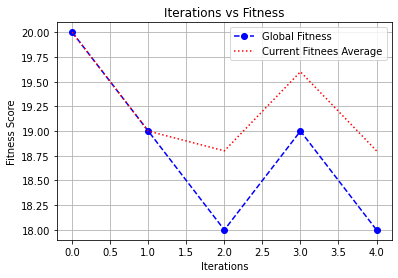

In [12]:
import FitnessFunction as fit
import Scramble 
import math
import random
from scrambleGenerator import makeMove
import matplotlib.pyplot as plt
from os import system, name 
import time
import sys
from itertools import groupby


def convert2Scramble(scramble):
	"""
	This will take a string "F F' F2"and will convert it into the form [['F',''],['F',"'"],['F','2']].
	We need to give it in the above format for the scrambling to work
	"""
	# Create an empty array to store the moves
	properScramble = []

	# Split based on the space between characters
	moves = scramble.split(" ")
	#print("Moves : ",moves)
	
	# Delete the last element as it is a space
	del moves[-1]	

	# Take every moves
	for m in moves:
		subMoves = ["", ""]
		if m == "F'" or m == "B'" or m == "R'" or m == "L'" or m == "U'" or m == "D'" or m == "F2" or m == "B2" or m == "R2" or m == "L2" or m == "U2" or m == "D2":
			subMoves[0] = m[0]
			subMoves[1] = m[1]
		else:
			subMoves[0] = m
			subMoves[1] = ""

		properScramble.append(subMoves)

	# Return the proper scramble format
	return properScramble


# This function will return the edge for a krill
def ReturnMove(legal_moves,krill_AllMoves,krill_Orientation,krill_fitness,krill):
	
	# Now we select the edge based on two conditions
	# We set the threshold as the fitness of the current state
	# If the fitness of any of the next edge is less than threshold we select that edge (greedy strategy)
	# If the fitness of all the edge is greater than or equal to the threshold we select the edge based on probability
	
	# Set the threshold as the current fitness of the krill
	threshold = krill_fitness[krill]
	
	# Now we will check if any of the edge has a fitness less than the threshold
	# We will set this flag to false
	# If any edge has a fitness less than threshold then we set this flag to true
	greedy = False
	move = ""	# This varaible is used to save the move applied and return it, if we find it
	for m in range(len(legal_moves)):
	
		# Apply that move to the cube
		properScramble = convert2Scramble(krill_AllMoves[krill] + legal_moves[m] + " ")
		
		# Find the length of the scramble
		noofMmoves = len(properScramble)	
		
		# Make that scramble and get the orientation
		scramble, cube_orientation = Scramble.scramble(True, properScramble, noofMmoves)
		
		# Now find the fitness value for the cube orientation
		fitnessValue = fit.fitness(cube_orientation)
		
		# Check if it is less than threshold, or if it is solved state
		if fitnessValue < threshold or cube_orientation == "yyyyyyyyyooooooooogggggggggwwwwwwwwwrrrrrrrrrbbbbbbbbb":
			
			# set the greedy flag to true
			greedy = True
			move = legal_moves[m]
			fv = fitnessValue
			
			# NOTE: We are not going to break out of the loop and return the move immediately
			# We will let this loop run till the end, in case we find another move which has fitness less than the current one
	
	# Now check if there was a move with fitness less than threshold, i.e. check if greedy flad is set
	if greedy == True:
		
		# Print the method used
		print("Method : Greedy",end=" ")
		
		# If it is true then return the move and the fitness value 
		# as there can be multiple fitness value for the same state
		return move, fv
	
	# If it is not true, then we will have to select the next move based on probability
	# This is similar to ACO, but here we don't use pheromone and all
	# Also since it is based on probability, we are not going to give partiality when the solved state is near.
	# As probability method, gives every edge a chance.
	else:
		
		# Print the method used
		print("Method : Probability",end=" ")
	
		# Assign probability to each moves
		# Initially the probability values are 0 for each moves
		probabilityDict = {"U":0,"U'":0,"U2":0,"D":0,"D'":0,"D2":0,"L":0,"L'":0,"L2":0,"R":0,"R'":0,"R2":0,"F":0,"F'":0,"F2":0,"B":0,"B'":0,"B2":0}
		
		# This dictionary will store the fitness for each move
		# We will use this dictionary to return the fitness value for the move we have selected
		# This is because a same state will have multiple fitness values, so we need to find the minimum from multiple evalution for the same state
		fitnessDict = {"U":0,"U'":0,"U2":0,"D":0,"D'":0,"D2":0,"L":0,"L'":0,"L2":0,"R":0,"R'":0,"R2":0,"F":0,"F'":0,"F2":0,"B":0,"B'":0,"B2":0}
		
		# The probability for the edges for the first at is given bytearray
		# P(i,j) = (1/fitness_of_next_move)/(sum_of(fitness_of_all_adjacent_edges))
		
		# Now take all the possible moves
		for m in range(len(legal_moves)):
			
			# Apply that move to the cube
			properScramble = convert2Scramble(krill_AllMoves[krill] + legal_moves[m] + " ")
			
			# Find the length of the scramble
			noofMmoves = len(properScramble)	
			
			# Make that scramble and get the orientation
			scramble, cube_orientation = Scramble.scramble(True, properScramble, noofMmoves)
			
			# Now find the fitness value for the cube orientation
			fitnessValue = fit.fitness(cube_orientation)
			
			# Save the fitness of the move in the fitness dictionary
			fitnessDict[legal_moves[m]] = fitnessValue
			
			# Now the eta value in the numberator is (quality of edge = 1/Lk i.e inverse of the distance)
			etaNumerator = (1/fitnessValue)
			
			#print("\n")
			#print("Move : ",legal_moves[m], end = " ")
			#print("Fitnees : ", fitnessValue,end = " ")
			#print("Eta : ",etaNumerator)
			
			# Now we need to find the find the fitness of all the edges connected to the current edge.
			# Then only we can find the eta value of denominator
			
			etaDenominator = 0
			
			# Now take all the adjacent edges
			for n in range(len(legal_moves)):
				
				# Apply that move to the cube
																	#First move		 # Adjacent moves
				properScramble = convert2Scramble(krill_AllMoves[krill] + legal_moves[m] + legal_moves[n] + " ")
				
				# Find the length of the scramble
				noofMmoves = len(properScramble)	
				
				# Make that scramble and get the orientation
				scramble, cube_orientation = Scramble.scramble(True, properScramble, noofMmoves)
				
				# Now find the fitness value for the cube orientation
				fitnessValue = fit.fitness(cube_orientation)
				
				# Now the eta value in the numberator is (quality of edge = 1/Lk i.e inverse of the distance)
				eta = (1/fitnessValue)
				
				# Now to get the denominator value we need to sum up the values in the denomintor
				etaDenominator = etaDenominator + eta
				
				#print("\n")
				#print("Move : ",legal_moves[n], end = " ")
				#print("Fitnees : ", fitnessValue,end = " ")
				#print("Eta : ",eta,end = " ")
				#print("Eta Denominator : ", etaDenominator)
			
			# Now find the probability of an edge
			probability = (etaNumerator/etaDenominator)
			
			# Now assign probability value to the edge in the probability dictionary
			probabilityDict[legal_moves[m]] = probability
			
			#print("\n")
			#print("Move : ",legal_moves[m])
			#print("Probability : ",probability)
			#print(probabilityDict)
		
		# Now print the probability dictionary for the ant
		#print(probabilityDict)
		
		# This probability distribution won't add up to 1.
		# So we need to take all of the probability and divide them by the sum
		sum = 0
		for i in probabilityDict: 
			sum = sum + probabilityDict[i] 
		#print("Sum : ",sum)
		
		# Divide each probability distribution by the sum
		for i in probabilityDict:
			probabilityDict[i] = probabilityDict[i]/sum
			
		# Now print the probability dictionary for the ant
		#print("\n")
		#print(probabilityDict)
		
		# Now make sure that the sum is 1
		#sum = 0
		#for i in probabilityDict: 
		#	sum = sum + probabilityDict[i] 
		#print("Sum : ",sum)
		
		# Now we need to sort the probability dictionary in ascending order

		# This will sort the dictionary, but it will return a list of tuple [(),(),..]
		dict = sorted(probabilityDict.items(), key=lambda x: x[1])   
		
		# So we need to convert the list of tuples back into a dictionary
		probabilityDict = {}
		for key,value in dict:
			probabilityDict[key] = value
		
		# Now we have got back our dictionary with the values sorted
		#print("\n")
		#print(probabilityDict)
		
		# Now we need to find the cumulative sum
		# We need to create a dictionary to hold the move and the cumulative distribution
		cumulativeDict = {}
		cumSum = 0
		for key,value in probabilityDict.items():
			cumSum = cumSum + value
			cumulativeDict[key] = cumSum
		
		#print("\n")
		#print(cumulativeDict)						
		
		# Now we need to select a random number
		number = random.random()
		#print("\n")
		#print("Random Number : ",number)
		
		# Now we need to find where the random number lands
		move = ""
		for key, value in cumulativeDict.items():
			# If the number generated is less than or equal to the value, we have got the required move.
			# After that just break out of the loop.
			if number <= value:
				move = key
				break
		
		# Return the move and the fintness value for that move
		return move, fitnessDict[move]


# This function will show all of the group of krill that are gathered at a node
def ShowGroup(nPop, krill_Orientation):
	# Print where the krill is at
	group = {}
	for k in range(nPop):
		if krill_Orientation[k] not in group.keys():
			group[krill_Orientation[k]] = [k]
		else:
			group[krill_Orientation[k]].append(k)

	for key,value in group.items():
		print(key, " : ",value)


# This function will do the reproduction operation
def Reproduction(krill1, krill2, krill_OrientationMoves, originalScramble, krill_fitness, krill_Orientation, krill_AllMoves, solution, iteration,nPop,start_time):
	"""
	krill1 - first krill
	krill2 - second krill
	n: Random gene point 
	krill_OrientationMoves: Moves applied to get the current orientation
	originalScramble: The initial scramble applied to the cube
	krill_fitness: Fitnees of the krill
	krill_Orientation: Orientation of the krill
	krill_AllMoves: All the moves applied to the cube, including the scramble
	solution: A datastructure to hold all the krill that found the solution
	iteration: Current iteration
	nPop: The total number of krill population
	start_time: The time at which the KHO loop started execution
	"""
	
	# The moves applied to the cube is in the form of strings
	# Convert the string to list for both parent krill
	# Last element will be a space, remove that
	krill1Moves = krill_OrientationMoves[krill1].split(" ")[:-1]
	krill2Moves = krill_OrientationMoves[krill2].split(" ")[:-1]
	
	# Now find the random gene point. We can use any of the list krill1Moves or krill2Moves as both are of same length
	n = random.randint(1,len(krill1Moves))
	
	# Now split them and interchange the tale
	childMoveList = krill1Moves[:n] + krill2Moves[n:]
	
	# Now this will be a list. Convert back to string
	newMove = " ".join([str(elem) for elem in childMoveList]) 
		
	print("Parents : ",krill1, "and ",krill2)
	print("Move Sequence of krill : ",krill1," = ",krill_OrientationMoves[krill1])
	print("Move Sequence of krill : ",krill2," = ",krill_OrientationMoves[krill2])
	print("Gene Point : ",n)
	
	# Now since this is a new krill, we need to append it to the datastructure
	# Now save the move applied by the krill
	krill_OrientationMoves.append(newMove + " ")
	
	# Now apply the move to the cube
	properScramble = convert2Scramble(originalScramble + newMove + " ")
	
	# Find the length of the scramble
	noofMmoves = len(properScramble)	
	
	# Make that scramble and get the orientation
	scramble, cube_orientation = Scramble.scramble(True, properScramble, noofMmoves)
	
	fitnessValue = fit.fitness(cube_orientation)
	
	print("New Krill : ", nPop,end=" ")
	print("Move Sequence : ", newMove,end=" ")
	print("Orientation : ",cube_orientation,end=" ")	
	print("Fitnees : ",fitnessValue)
	krill_fitness.append(fitnessValue)
	
	# Now save the orientation
	krill_Orientation.append(cube_orientation)
	
	# Now save the move applied
	krill_AllMoves.append(scramble)
	
	# If the cube is solved
	# This will be append to the end of the datastructure
	if krill_Orientation[-1] == "yyyyyyyyyooooooooogggggggggwwwwwwwwwrrrrrrrrrbbbbbbbbb":
		
		# Find the length of the solution
		# The moves applied is a string. So split it by space and remove the last character as it is a space.
		# This is needed to find the length of the solution. 
		# If it was a string then it would count the spaces.
		solutionMoves = krill_OrientationMoves[-1].split(" ")[:-1]
		
		intermediate_time = time.time()	# This is where a particle will find the solved state
		solve_time = intermediate_time - start_time # The time for a particle to find the solution

		# Iteration, krill, orientation, solution, solution length, time
		# Since this is a new krill that is born, it will be append to the end of every datastructure
		solution.append([iteration, nPop, krill_Orientation[-1], krill_OrientationMoves[-1], len(solutionMoves), solve_time])	


# This function will do the mutation
def Mutation(fitnessThreshold, nPop, krill_fitness, krill_AllMoves, krill_Orientation, krill_OrientationMoves, legal_moves,originalScramble,start_time):
	
	"""
	fitnessThreshold: The threshold at which we decide if a krill is fit or not
	nPop: Population size
	krill_fitness: A datastructure that holds the fitness of all the krill
	krill_AllMoves: A datastructure that holds all the moves applied to the cube starting with the scramble
	krill_Orientation: A datastructure that holds the orientation of all the krills
	krill_OrientationMoves: A datastructure that hold the moves applied to the cube, after the scramble
	legal_moves: the set of all possible moves that can be applied to the cube
	originalScramble: The scramble applied to the cube
	start_time: The time at which the loop started its execution
	"""

	print("Threshold : ",fitnessThreshold)
	
	# Take every krill and check if its fitness is greater than the threshold
	for krill in range(nPop):

		print("Krill : ",krill,end = " ")
		print("Fitnees : ",krill_fitness[krill],end= " ")

		# If the fitness of krill is less than the threshold, then no mutation
		if krill_fitness[krill] <= fitnessThreshold:
			print("No mutation")

		# Else do the mutation
		else:
			print("Mutation is needed")
			print("Old Moves : ",krill_OrientationMoves[krill],end=" ")
			print("Old Orientation : ",krill_Orientation[krill],end=" ")

			# The moves applied to the krill is in the form of a string. 
			# Convert it to a list, remove the last element as it is a space
			krillMoves = krill_OrientationMoves[krill].split(" ")[:-1]

			# Now decide how many gene points that you want to change
			points = random.randint(1,len(krillMoves))
			print("Points : ",points)

			# Now use a list to store all the index of all the gene points that you want to change
			indexList = []

			# Run this loop till we have found the index points equal to the points that we want to change
			while(len(indexList) != points):

				# Generate a radom index point 
				# Make sure that the index points are in the appropriate value
				# If move lenght is 7, then index is 0 to 6
				n = random.randint(0,len(krillMoves)-1)

				# If this index point is not in the list
				if n not in indexList:
					indexList.append(n)

				# If the gene point is in already in the list, then continue
				else:
					continue

			# Now take every index that we found
			for i in indexList:

				# Change the move in that index with a random move
				krillMoves[i] = random.choice(legal_moves)

			# Now this will be a list. Convert back to string
			newMove = " ".join([str(elem) for elem in krillMoves]) 

			# Now since the moves applied to the krill has changed, change the move in the datastructure
			krill_OrientationMoves[krill] = newMove + " "

			# Now apply the move to the cube
			properScramble = convert2Scramble(originalScramble + newMove + " ")

			# Find the length of the scramble
			noofMmoves = len(properScramble)	

			# Make that scramble and get the orientation
			scramble, cube_orientation = Scramble.scramble(True, properScramble, noofMmoves)

			fitnessValue = fit.fitness(cube_orientation)

			print("New Moves : ", newMove,end=" ")
			print("New Orientation : ",cube_orientation,end=" ")	
			print("New Fitnees : ",fitnessValue)
			krill_fitness[krill] = fitnessValue

			# Now save the orientation
			krill_Orientation[krill] = cube_orientation

			# Now save the move applied
			krill_AllMoves[krill] = scramble

			# If the cube is solved
			# This will be append to the end of the datastructure
			if krill_Orientation[krill] == "yyyyyyyyyooooooooogggggggggwwwwwwwwwrrrrrrrrrbbbbbbbbb":

				# Find the length of the solution
				# The moves applied is a string. So split it by space and remove the last character as it is a space.
				# This is needed to find the length of the solution. 
				# If it was a string then it would count the spaces.
				solutionMoves = krill_OrientationMoves[krill].split(" ")[:-1]
				
				intermediate_time = time.time()	# This is where a particle will find the solved state
				solve_time = intermediate_time - start_time # The time for a particle to find the solution

				# Iteration, krill, orientation, solution, solution length, time
				# Since this is a new krill that is born, it will be append to the end of every datastructure
				solution.append([iteration, krill, krill_Orientation[krill], krill_OrientationMoves[krill], len(solutionMoves), solve_time])	


# Function definition
def KHO(iterations, krills, flag, scramble):
	
	# Problem definition for the KHO
	# This returns the scramble and the orientation of the stickers in the cube
		
	# If it is a random scramble
	if flag == False:
		# Problem definition
		scramble, cube_orientation = Scramble.scramble(flag,scramble,0)	# This returns the scramble and the orientation of the stickers in the cube
	
	# Else if it is a manual scramble
	else:
		# Now apply the move to the cube
		properScramble = convert2Scramble(scramble)
		
		# Find the length of the scramble
		noofMmoves = len(properScramble)	
		
		# Make that scramble and get the orientation
		scramble, cube_orientation = Scramble.scramble(flag, properScramble, noofMmoves)
	
	# Save the scramble used, we might want to show it later
	originalScramble = scramble
	
	# Save the initial cube orientation, we might want to show it later
	initialOrientation = cube_orientation
	
	# Original Fitnees score, we might want to show it later.
	originalFitness = fit.fitness(cube_orientation)
	
	# Print the initial orientation
	print("Scramble : ",originalScramble)
	print("Initial cube orientation: ", cube_orientation)
	print("Initial Fitnees : ",originalFitness)
	print("\n")
	
	# Parameters of the Ant colony optimization
	maxIter = iterations	# Maximum number of iterations
	nPop = originalPopulation = krills	# Maximum population size i.e th total number of krills
	
	# Print the maximum Iteration and the total population of the krills
	print("Maximum Iteration : ",maxIter)
	print("Total Population : ",nPop)
	
	# Varaible declarartion. We need to create data structures to hold certain varaible values
	
	# A data structure to hold the legal moves available  i.e. U,U',U2,...,R,R',R2.
	# Since Kociemba works on half turn metric where two turns of the side are counted as one move we will use half turn metric.
	legal_moves = ["U", "U'", "U2", "D", "D'","D2", "L","L'", "L2", "R", "R'", "R2", "F","F'", "F2", "B", "B'", "B2"]	
	
	# This datastructure will hold all the moves applied from the initial state, starting with the scramble
	krill_AllMoves = []	
	
	# A data structure to hold the position of each krill i.e which orientation they are in
	krill_Orientation = []
	
	# A data structure to hold the moves that made the krill to reach the current position, does not include the scramble
	krill_OrientationMoves = [] 
	
	# This varaible will hold the fitness value for each krill
	krill_fitness = []
	
	# This list is used to hold all the krill that found the solved state and other information like the iteration it found the solution, length etc.
	solution = []	
	
	# Initialization of varibles. Here we are going to initailze all the krill
	for i in range(nPop):
		
		# We are going to append the scramble used as that was the only move applied till now
		krill_AllMoves.append(scramble)	
		
		# Initially all the krill will be in the initial scrambled position	
		krill_Orientation.append(cube_orientation)	

		# Initially since no moves were made the data structure is empty
		krill_OrientationMoves.append("")	
		
		# The fitness value for all krill will be the fitness value for the scrambled state
		krill_fitness.append(originalFitness)
	
	"""
	# Now print the details for each krill
	for i in range(nPop):
		print("Krill : ",i)
		print("All moves : ",krill_AllMoves[i])
		print("Orientation : ",krill_Orientation[i])
		print("Moves applied to reach orientation from scrambled state : ",krill_OrientationMoves[i])
		print("Fitnees : ",krill_fitness[i])
		print("\n")
	"""
	
	# This varaible is used for plotting the graph
	xIter = []
	yFitnessCurrent = []
	yFitnessGlobal = []
	
	# Number of iterations
	start_time = time.time()	# This is were the execution begins
	
	# Continue for the total number of iterations
	for iteration in range(maxIter):
		
		# We need to find values for plotting
		xIter.append(iteration)
		sumFitness = 0
		for i in range(len(krill_fitness)):
			sumFitness = sumFitness + krill_fitness[i]
		yFitnessCurrent.append(sumFitness/nPop)	# We are going to append the average fitness of all ants, for the iteration
		yFitnessGlobal.append(min(krill_fitness))
		
		
		# If all the krill has found the solution, then break out of the loop
		if len(solution) == nPop:
			break
		
		#system('cls')
		print("\n")
		print("Iteration : ",iteration)
		
		##********** Edge Selection **********##
		print("********** Edge Selection Stage **********")			
		# For all the krill in the population
		for krill in range(nPop):
			
			# Print which krill it is 
			print("Krill : ",krill,end = " ")
			
			# Print the orientation of the krill
			print("Orientation : ",krill_Orientation[krill],end = " ")
			
			# Print the current fitness o the krill
			print("Current Fitnees : ",krill_fitness[krill],end= " ")
			
			if krill_Orientation[krill] == "yyyyyyyyyooooooooogggggggggwwwwwwwwwrrrrrrrrrbbbbbbbbb":
				print("Solution found for krill")
			
			# If the ant has not reached the solved state.
			if krill_Orientation[krill] != "yyyyyyyyyooooooooogggggggggwwwwwwwwwrrrrrrrrrbbbbbbbbb":
			
				# Now select the next egde/move for the krill and find its fitness
				move, fitnessValue1 = ReturnMove(legal_moves,krill_AllMoves,krill_Orientation,krill_fitness,krill)
				
				# Print the move applied
				print("Move : ",move,end=" ")
				
				# Now save the move applied by the ant
				krill_OrientationMoves[krill] = krill_OrientationMoves[krill] + move + " "
				
				# Now apply the move to the cube
				properScramble = convert2Scramble(krill_AllMoves[krill] + move + " ")
				
				# Find the length of the scramble
				noofMmoves = len(properScramble)	
				
				# Make that scramble and get the orientation
				scramble, cube_orientation = Scramble.scramble(True, properScramble, noofMmoves)
				
				# Now find the fitness value and save it
				# We know that some state, will have multiple fintness.
				# When we give the state to Kociemba multiple times it will give sometimes give differenent fitness
				# So here we are finding the minimum fintness value by running the Kociemba on the same state twice
				fitnessValue2 = fit.fitness(cube_orientation)				
				fitnessValue = min([fitnessValue1, fitnessValue2])
				print("New Fitnees : ",fitnessValue)
				krill_fitness[krill] = fitnessValue
				
				# Now save the orientation
				krill_Orientation[krill] = cube_orientation
				
				# Now save the move applied
				krill_AllMoves[krill] = scramble
				
				# If the cube is solved
				if krill_Orientation[krill] == "yyyyyyyyyooooooooogggggggggwwwwwwwwwrrrrrrrrrbbbbbbbbb":
					
					# Find the length of the solution
					# The moves applied is a string. So split it by space and remove the last character as it is a space.
					# This is needed to find the length of the solution. 
					# If it was a string then it would count the spaces.
					solutionMoves = krill_OrientationMoves[krill].split(" ")[:-1]
					
					intermediate_time = time.time()	# This is where a particle will find the solved state
					solve_time = intermediate_time - start_time # The time for a particle to find the solution

					# Iteration, krill, orientation, solution, solution length, time
					solution.append([iteration, krill, krill_Orientation[krill], krill_OrientationMoves[krill], len(solutionMoves),solve_time])	
		
		# Show the group of krill that are gathered at a node
		ShowGroup(nPop, krill_Orientation)
		
		##********** Killing of krill that are not fit **********##
		# We will kill off the krill that have fitness greater that 50% of the global minimum value
		
		# Now find the value of the global minimum
		globalMin = min(krill_fitness)
		
		# Set fitness threshold
		fitnessThreshold = (globalMin // 2) + globalMin
		
		# This variable is used to keep track of all th krill that was kill
		killed = 0
		
		print("\n\n")
		print("********** Killing Stage **********")
		print("Global Minimum : ",globalMin)
		print("Fitnees Threshold : ", fitnessThreshold)
		
		# Take every krill
		# Pop element from the back
		for krill in range(nPop-1,-1,-1):
		
			# If the fitness of the is greater than the threshold, then kill it off
			if krill_fitness[krill] > fitnessThreshold:
				
				# Remove all the parameters associated with the krill
				# Also since we are using pop, the  next element will get pushed to the current index 
				print("Killed : ",krill)
				krill_AllMoves.pop(krill)	
				krill_Orientation.pop(krill)	
				krill_OrientationMoves.pop(krill)	
				krill_fitness.pop(krill)		
				
				# Increment the number of krill that was killed
				killed += 1
		
		# Decrease population size
		nPop = nPop - killed
		
		if killed == 0:
			print("No krill was killed")
		
		# Now show the group:
		ShowGroup(nPop, krill_Orientation)		
		
		
		##********** Here we are going to do reproduction, to make sure that population is back to normal **********##
		# We are going to do reproduction till population is back to normal
		
		print("\n\n")
		print("********** Reproduction Stage **********")
		
		# If no krill was killed then no need for reproduction
		if killed == 0:
			print("No reproduction as no krill was killed.")
		
		# If only one krill is left, then we can't do reproduction
		elif nPop == 1:
				print("No reproduction possible as only one krill is left.")
		
		else:
			print("Reproduction")
			populationRestored = False
			while nPop != originalPopulation:
				
				# Take the moves applied to the first krill
				for i in range(len(krill_OrientationMoves)):
					
					# Select the next krill
					for j in range(len(krill_OrientationMoves)):
						
						# Skip to next krill if i and j are same, as we dont want the krill to reproduce with itself
						if i == j:
							continue
						
						# Do reproduction between krill 1 and krill 2 and increase population size
						print("\n")
						print("Reproduction between krill ",i, " and krill ",j)
						Reproduction(i, j, krill_OrientationMoves, originalScramble, krill_fitness, krill_Orientation, krill_AllMoves, solution, iteration,nPop, start_time)
						nPop += 1
						
						# If population is restored break out of the loop
						if nPop == originalPopulation:
							print("Population restored to ",nPop)
							populationRestored = True
							break
						
						# Else do reproduction between krill 2 and krill 1 and increase population size
						print("\n")
						print("Reproduction between krill ",j, " and krill ",i)
						Reproduction(j, i, krill_OrientationMoves, originalScramble, krill_fitness, krill_Orientation, krill_AllMoves, solution, iteration,nPop,start_time)
						nPop += 1
						
						# If population is restored break out of the loop
						if nPop == originalPopulation:
							print("Population restored to ",nPop)
							populationRestored = True
							break
					
					# Break out of for loop for i
					if populationRestored:
						break
				
				# Break out of while loop
				if populationRestored:
					break
					
		
		##********** Here we are going to do mutation, i.e. changing the move sequence of krill that have fitness greater than threshold **********##
		# Mutation of krill, whose fitness is greater than the threshold
		# This can happen when the child has a fitness greater than the threshold
		
		print("\n\n")
		print("********** Mutation Stage **********")
		
		# Call the mutation function
		Mutation(fitnessThreshold, nPop, krill_fitness, krill_AllMoves, krill_Orientation, krill_OrientationMoves,legal_moves, originalScramble,start_time)
		
	end_time = time.time()	# This is where the entire PSO loop finishes execution
	total_time = end_time - start_time	# This is the total time needed for the loop execution
	
	# Print the initial cube orientation
	print("\n")
	print("Cube orientation: Yellow on top and green on front.")
	print("Reading order goes: Up, Right, Front, Down, Left, Back.")
	print("Scramble: ", originalScramble)
	print("Initial cube orientation : ",initialOrientation)
	
	# Print the solution detail for each krill
	for sol in solution:
		print("\n")
		print("Iteration : ",sol[0])
		print("Krill : ",sol[1])
		print("Orientation : ", sol[2])
		print("Solution : ",sol[3])
		print("Length : ",sol[4])
		print("Time : ",sol[5])
	
	# If the solution was not found print the appropriate information
	if len(solution)==0:
		print("\n")
		print("Solution was not found by any krill")
		print("The total number of krill that found solution: ",len(solution),"/",originalPopulation)	# 0 particles solved it
		print("Original Solution Length: ", originalFitness)
		print("Average solution length: NIL")	# Since the solution was not found	
		print("Iteration at which the first solution was found: NIL")	# Since the solution was not found
		print("Iteration at which the last krill found the solution: NIL")	# Since the solution was not found
		print("Average iterations it takes for the next krill to reach solved state: NIL")	# Since the solution was not found
		print("Total time for loop execution : ",total_time)
	
	# Else if the solution was found
	else:
		# Print the details:
		# Find the average length of the solution
		print("\n")
		sumSol = 0
		for sol in solution:
			sumSol = sumSol + sol[4]
					
		averageSol = sumSol/len(solution)
		
		print("The total number of krill that found solution: ",len(solution),"/",originalPopulation)
		print("Original Solution Length: ", originalFitness)
		print("Average solution length: ", averageSol)	
		
		# Find the average iteration and time it takes for the next particle to reach the solved state
		sumIter = 0
		sumIterTime = 0
		for i in range(len(solution)):
			if (i+1) >= len(solution):
				break
			else:
				sumIter = sumIter + (solution[i+1][0]-solution[i][0])
				sumIterTime = sumIterTime + (solution[i+1][5]-solution[i][5])
		
		averageIter = sumIter/len(solution)
		averageIterTime = sumIterTime/len(solution)
		
		
		# The minimum iteration at which the solution was found and also the maximum iteration	
		print("Iteration at which the first solution was found: ",solution[0][0])		
		print("Iteration at which the last krill found the solution: ", solution[-1][0])
		print("Average iterations it takes for the next krill to reach solved state: ",averageIter)
		print("\n")
		print("Time required to find the first solution : ",solution[0][5],"seconds")	# At the fifth index of the solution vector the time is stored
		print("Total time for KHO loop execution: ", solution[-1][5],"seconds")
		print("Average time it takes for the next krill to reach solved state: ",averageIterTime, "seconds")
		
	# Plotting the change of personal best with each iteration for particle
	plt.grid(True)
	plt.plot(xIter,yFitnessGlobal,c="blue",linestyle="--",marker="o")
	plt.plot(xIter,yFitnessCurrent,c="red",linestyle=':')	# Plot iteration vs fitness
	
	plt.xlabel('Iterations')	# naming the x axis as iterations
	plt.ylabel('Fitness Score')	# naming the y axis as fitness score	
	plt.title('Iterations vs Fitness')	# giving a title to my graph 
	plt.legend(["Global Fitness","Current Fitnees Average"]) 	
	plt.show()
	

# Main program
if __name__ == "__main__":
	print("\n")
	print("Krill Herd Optimization")
	iterations = int(input("Enter the number of iterations : "))
	krills = int(input("Enter the number of krills : "))
	randomOrManual = input("Type M for manual scramble or R for random scrabmle : ")
	if randomOrManual == "R":
		flag = False
		scramble = ""
	elif randomOrManual == "M":
		flag = True
		scramble = input("Type scramble : ")
		
	# Function call
	# Add space to the scramble entered by the user, implementation reason.
	KHO(iterations, krills, flag, scramble+" ")	# Calling the ACO algorithm